# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

D = np.loadtxt('data/lin_reg.txt', delimiter=',')
X = D[:, :-1]
Y = D[:, -1]
eps = 1e-12
X = (X - X.mean(axis=0))/(X.std(axis = 0) + eps)
Y = Y.reshape((-1,1))
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [3]:
class LinearModel(torch.nn.Module):
    def __init__(self,in_features):
        super(LinearModel,self).__init__()
        self.fc = torch.nn.Linear(in_features, 1, bias=True)
        
    def forward(self,x):
        x = self.fc(x)
        return x

In [4]:
def train_model(model,criterion, optimizer, X_train, y_train, X_val=None, y_val=None, batch_size = 16, epochs = 100, verbose = True):
    history, val_history = [], []
    for epoch in range(1, epochs + 1):
        fraction = X_train.shape[0] // batch_size
        batch_range = range(fraction)
        for i in batch_range:
            x_batch = X_train[i * batch_size: (i + 1) * batch_size]
            y_batch = y_train[i * batch_size: (i + 1) * batch_size]
            optimizer.zero_grad()
            predictions = model(x_batch)
            loss = criterion(y_batch, predictions)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        with torch.no_grad():
            history.append(loss.item())
            if (X_val is not None) or (y_val is not None):
                val_predictions = model(X_val)
                val_history.append(criterion(val_predictions, y_val).item())
        if verbose:
            output = f'epoch {epoch}: {history[-1]}' if (X_val is None) or (y_val is None) else f'epoch {epoch}: {loss.item()}; val loss: {val_history[-1]}'
            print(output)
    return history, val_history

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования.

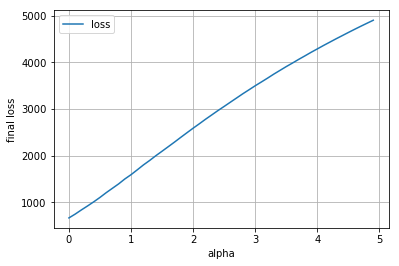

In [5]:
alpha_range = np.arange(0.0, 5.0, 0.1)
loss_list = []
for alpha in alpha_range:
    model = LinearModel(X.shape[1])
    mse_loss = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr = 1e-4, weight_decay = alpha)
    history, val_history = train_model(model, mse_loss, optimizer, X, Y, epochs = 100, batch_size = 16, verbose = False)
    model.eval()
    prediction = model(X)
    loss = mse_loss(prediction, Y)
    loss_list.append(loss.item())

plt.plot(alpha_range, loss_list, label = 'loss')
plt.xlabel("alpha")
plt.ylabel("final loss")
plt.legend() 
plt.grid()
plt.show()

2. Подготовьте исходные данные для 5 fold CV.

In [6]:
def k_fold_training(X, y, k, epochs, lr, weight_decay_param, batch_size = 16, verbose = True):
    num_val_samples = len(X) // k    
    models = []
    history_list = []
    train_scores = []
    val_scores = []
    
    for i in range(k):
        if verbose:
            print('fold #', i +1)
        val_data = X[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = Y[i * num_val_samples: (i + 1) * num_val_samples]
        partial_train_data = torch.Tensor(np.concatenate( [X[:i * num_val_samples], X[(i + 1) * num_val_samples:]], axis=0))
        partial_train_targets = torch.Tensor(np.concatenate([y[:i * num_val_samples], y[(i + 1) * num_val_samples:]], axis=0))
        model = LinearModel(X.shape[1])
        criterion = torch.nn.MSELoss() 
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay = weight_decay_param)

        history = train_model(model, criterion, optimizer, partial_train_data, partial_train_targets, val_data, val_targets,
                               batch_size = batch_size,  epochs = epochs, verbose = False)
        with torch.no_grad():
            val_score = criterion(model(val_data), val_targets)
            train_score = criterion(model(partial_train_data), partial_train_targets)
        if verbose:
            print(f'val_score: {val_score}')
        
        models.append(model)
        history_list.append(history)
        train_scores.append(train_score)
        val_scores.append(val_score)
    
    return {'models': models, 'history': history_list, 'train_scores': train_scores, 'val_scores': val_scores}
    

In [7]:
info = k_fold_training(X, Y, 5, 50, 0.1, weight_decay_param=0.1)

fold # 1
val_score: 111.44230651855469
fold # 2
val_score: 112.59626007080078
fold # 3
val_score: 135.98614501953125
fold # 4
val_score: 123.69572448730469
fold # 5
val_score: 135.38833618164062


3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.

In [8]:
def find_alpha(X, Y, steps, lr_range, alpha_range, verbose = True, epochs = 100, batch_size = 16):
    mean_scores = []
    params_list = []
    for i in range(1, steps+1):
        random_lr = np.random.uniform(*lr_range)
        random_alpha = np.random.uniform(*alpha_range)
        params = {'lr': random_lr, 'weight_decay': random_alpha}
        if verbose:
            print(f'{i}) random_lr: {random_lr}; random_alpha: {random_alpha}')
        
        info = k_fold_training(X, Y, 5, epochs, random_lr, random_alpha, batch_size = batch_size, verbose = False)
        mean_score = np.array(info['val_scores']).mean()
        if verbose:
            print(f'mean score: {mean_score}\n')
        mean_scores.append(mean_score)
        params_list.append(params)
    
    min_index = np.array(mean_scores).argmin()
    if verbose:
        print(f'optimal params: {params_list[min_index]}; mean score: {mean_scores[min_index]}')
    return params_list[min_index]
        

In [ ]:
best_params = find_alpha(X, Y, 100, [1e-5, 1e-1], [0.0, 1.0])

1) random_lr: 0.06468894440483262; random_alpha: 0.056852228864628596
mean score: 109.0457992553711

2) random_lr: 0.013790493318379966; random_alpha: 0.7010603659880986
mean score: 633.3718872070312

3) random_lr: 0.07502446882143768; random_alpha: 0.1826871861625866
mean score: 159.0795440673828

4) random_lr: 0.07910410068941726; random_alpha: 0.8551892594542458
mean score: 871.0813598632812

5) random_lr: 0.03575518522246524; random_alpha: 0.5567155497590607
mean score: 464.1294860839844

6) random_lr: 0.09133234229397066; random_alpha: 0.04544788248232434
mean score: 107.8514404296875

7) random_lr: 0.015353972190062674; random_alpha: 0.7651140899652342
mean score: 705.8257446289062

8) random_lr: 0.0586952729231634; random_alpha: 0.7914957534169174
mean score: 747.0321044921875

9) random_lr: 0.0908136527812168; random_alpha: 0.25901602599887297
mean score: 214.22476196289062

10) random_lr: 0.024297721697507584; random_alpha: 0.7581513926394893
mean score: 688.4352416992188

11)

4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [ ]:
model = LinearModel(X.shape[1])
mse_loss = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), **best_params)

history, val_history = train_model(model, mse_loss, optimizer, X[200:], Y[200:], X[:200], Y[:200], epochs = 200, batch_size = 16,
        verbose = True)

In [ ]:
print(val_history[-1])
plt.plot(range(len(history)), history, label = 'loss')
plt.plot(range(len(val_history)), val_history, label = 'val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend() 
plt.grid()
plt.show()